# Debugging SageMaker XGBoost Training Jobs with Tornasole

## Overview

Tornasole is a new capability of Amazon SageMaker that allows debugging machine learning training. 
Tornasole helps you to monitor your training in near real time using rules and would provide you
alerts, once it has detected inconsistency in training. 

Using Tornasole is a two step process: Saving tensors and Analysis.
Let's look at each one of them closely.

### Saving tensors (and scalars)

In deep learning algorithms, tensors define the state of the training job
at any particular instant in its lifecycle.
Tornasole exposes a library which allows you to capture these tensors and
save them for analysis.
Although XGBoost is not a deep learning algorithm, Tornasole is highly customizable
and can help provide interpretability by saving insightful metrics, such as
performance metrics or feature importances, at different frequencies.
Refer to [DeveloperGuide_XGBoost](../../DeveloperGuide_XG.md) for details on how to
save the metrics you want.

### Analysis

Analysis of the tensors emitted is captured by the Tornasole concept called ***Rules***.
On a very broad level, a rule is a python code used to detect certain conditions during training.
Some of the conditions that a data scientist training a deep learning model may care about are
monitoring for gradients getting too large or too small, detecting overfitting, and so on.
Tornasole will come pre-packaged with certain rules.
Users can write their own rules using the Tornasole APIs.
You can also analyze raw tensor data outside of the Rules construct in say, a Sagemaker notebook,
using Tornasole's full set of APIs. 
Please refer [DeveloperGuide_Rules](../../../../rules/DeveloperGuide_Rules.md) for more details about analysis.

This example guides you through installation of the required components for emitting tensors in a 
SageMaker training job and applying a rule over the tensors to monitor the live status of the job. 

## Setup

We will also install the required tools which will allow emission of tensors (saving tensors) and application of rules to analyze them. This is only for the purposes of this private beta. Once we do this, we will be ready to use Tornasole.

You'll probably have to restart this notebook after running the following code cell.

In [1]:
! aws s3 sync s3://tornasole-external-preview-use1/sdk/ ~/SageMaker/tornasole-preview-sdk/
! pip3 -q install ~/SageMaker/tornasole-preview-sdk/ts-binaries/tornasole_rules/py3/latest/tornasole-0.3.4-py2.py3-none-any.whl --user
! chmod +x ~/SageMaker/tornasole-preview-sdk/installer.sh && ~/SageMaker/tornasole-preview-sdk/installer.sh

download: s3://tornasole-external-preview-use1/sdk/installer.sh to ../../../../tornasole-preview-sdk/installer.sh
download: s3://tornasole-external-preview-use1/sdk/sagemaker-tornasole-latest.tar.gz to ../../../../tornasole-preview-sdk/sagemaker-tornasole-latest.tar.gz
download: s3://tornasole-external-preview-use1/sdk/sagemaker-1.35.2.dev0.tar.gz to ../../../../tornasole-preview-sdk/sagemaker-1.35.2.dev0.tar.gz
download: s3://tornasole-external-preview-use1/sdk/sagemaker-tornasole.json to ../../../../tornasole-preview-sdk/sagemaker-tornasole.json
awscli 1.16.76 has requirement botocore==1.12.66, but you'll have botocore 1.12.91 which is incompatible.
awscli 1.16.76 has requirement s3transfer<0.2.0,>=0.1.12, but you'll have s3transfer 0.2.1 which is incompatible.
You are using pip version 19.0.2, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Installing requirements...
tornasole 0.3.4 has requirement boto3==1.9.91, but yo

### If you running this notebook for the first time, please wait for the above setup to complete and restart the notebook by selecting *Kernel -> Restart Kernel* before proceeding.

We have built SageMaker XGBoost containers with Tornasole. You can use them from ECR from SageMaker. Here are the links to the images. Please use the image from the appropriate region in which you want your jobs to run.

In [1]:
import os
import boto3
from sagemaker import get_execution_role

# Below changes the region to be one where this notebook is running
REGION = boto3.Session().region_name
ROLE = get_execution_role()
os.environ["AWS_REGION"] = REGION

TAG = "latest"
docker_image_name = "072677473360.dkr.ecr.{}.amazonaws.com/tornasole-preprod-xgboost-0.90-cpu:{}".format(REGION, TAG)

## Training XGBoost models in SageMaker with Tornasole

### SageMaker XGBoost as a framwork

We'll train a few XGBoost models in this notebook with Tornasole enabled and monitor the training jobs with Tornasole Rules. This will be done using SageMaker XGBoost 0.90 Container as a framework. The [XGBoost algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) can be used as a built-in algorithm or as a framework such TensorFlow. Using XGBoost as a framework provides more flexible than using it as a built-in algorithm as it enables more advanced scenarios that allow pre-processing and post-processing scripts to be incorporated into your training script.

Let us first train a simple example training script [xgboost_abalone_basic_hook_demo.py](../scripts/xgboost_abalone_basic_hook_demo.py) with XGBoost enabled in SageMaker using the SageMaker Estimator API, along with a LossNotDecreasing Rule to monitor the training job in realtime. A Tornasole Rule is essentially python code which analyzes tensors saved by tornasole and validates some condition. LossNotDecreasing rule is a first party (1P) rule provided by Tornasole. During training, Tornasole will capture tensors as specified in its configuration and LossNotDecreasing Rule job will monitor whether you are running into a situation where loss is not going down. The rule will emit a cloudwatch event if it finds that loss is not decreasing during training.

### Enabling Tornasole in the script

You can see in the script that we have made a couple of simple changes to enable Tornasole. We created a TornasoleHook which we pass as a callback function when creating a Booster. We passed a SaveConfig object telling the hook to save the evaluation metrics, feature importances, and SHAP values at regular intervals. Note that Tornasole is highly configurable, you can choose exactly what to save. The changes are described in a bit more detail below after we train this example as well as in even more detail in our [Developer Guide for XGBoost](../../DeveloperGuide_XG.md). 

```python
from tornasole.xgboost import TornasoleHook, SaveConfig

save_config = SaveConfig(save_interval=frequency)
hook = TornasoleHook(
    save_config=save_config,
    shap_data=shap_data)

bst = xgboost.train(
    ...
    callbacks=[hook]
)
```

### XGBoost for Regression

We use the [Abalone data](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html) originally from the [UCI data repository](https://archive.ics.uci.edu/ml/datasets/abalone). More details about the original dataset can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names).  In the libsvm converted [version](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html), the nominal feature (Male/Female/Infant) has been converted into a real valued feature. Age of abalone is to be predicted from eight physical measurements.

Refer to [XGBoost for Regression](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/xgboost_abalone)
for an example of using regression from Amazon SageMaker's implementation of
[XGBoost](https://github.com/dmlc/xgboost).

In [2]:
entry_point_script = "../scripts/xgboost_abalone_basic_hook_demo.py"

hyperparameters={
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.7",
    "silent": "0",
    "objective": "reg:linear",
    "num_round": "50",
    "tornasole_frequency": "2"
}

In [3]:
from sagemaker.xgboost import XGBoost

estimator = XGBoost(
    image_name=docker_image_name,
    base_job_name="demo-tornasole-xgboost",
    entry_point=entry_point_script,
    hyperparameters=hyperparameters,
    train_instance_type="ml.m4.4xlarge",
    train_instance_count=1,
    framework_version="0.90-1",
    py_version="py3",
    role=ROLE,
    
    # These are Tornasole specific parameters, 
    # debug=True means rule specified in rules_specification 
    # will run as rule job. 
    # Below, we specify to run the first party rule LossNotDecreasing
    # on a ml.c5.4xlarge instance
    debug=True,
    rules_specification=[
        {
        "RuleName": "LossNotDecreasing",
        "InstanceType": "ml.c5.4xlarge",
        "RuntimeConfigurations": {
            "use_losses_collection": "False",
            "tensor_regex": "train-rmse,validation-rmse",
            "num_steps" : "10"
            }
        }
    ]
)


*Note that Tornasole is only supported for `py_version='py3'` currently.*

In [4]:
# This is a fire and forget event.
# By setting wait=False, we just submit the job to run in the background.
# In the background SageMaker will spin off 1 training job and 1 rule job for you.
# Please follow this notebook to see status of the training job and the rule job.
estimator.fit(wait=False)

### Result
As a result of the above command, SageMaker will spin off 1 training job and 1 rule job for you - the first one being the job which produces the tensors to be analyzed and the second one, which analyzes the tensors to check if `train-rmse` and `validation-rmse` are not decreasing at any point during training.

### Describing the training job
We can check the status of the training job by running the following command:

In [5]:
# Below command will give the status of training job
# Note: In the output of below command you will see DebugConfig parameter 
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)

In [6]:
# The status of the training job can be seen below
description["TrainingJobStatus"]

'InProgress'

Once your training job is started SageMaker will spin up a rule execution job to run the LossNotDecreasing rule.

### Tornasole specific parameters in the description
**DebugConfig** parameter has details about Tornasole related configuration. The key parameters to look for below are

*S3OutputPath* : This is the path where output tensors from tornasole is getting saved.  
*RuleConfig*' : This parameter tells about the rule config parameter that was passed when creating the trainning job. In this you should be able to see details of the rule that ran for training. 

In [7]:
description["DebugConfig"]

{'DebugHookConfig': {'LocalPath': '/opt/ml/output/tensors',
  'S3OutputPath': 's3://sagemaker-us-west-2-959484541615/tensors-demo-tornasole-xgboost-2019-09-10-05-20-56-378',
  'DebugHookSpecificationList': []},
 'RuleConfig': {'RuleSpecificationList': [{'RuleName': 'LossNotDecreasing',
    'RuleEvaluatorImage': '453379255795.dkr.ecr.us-west-2.amazonaws.com/script-rule-executor:latest',
    'InstanceType': 'ml.c5.4xlarge',
    'VolumeSizeInGB': 100,
    'RuntimeConfigurations': {'num_steps': '10',
     'tensor_regex': 'train-rmse,validation-rmse',
     'use_losses_collection': 'False'}}]}}

### Check the status of the Rule Execution Job
To get the rule execution job that SageMaker started for you, run the command below and it shows you the `RuleName`, `RuleStatus`, `FailureReason` if any, and `RuleExecutionJobArn`. If the tensors meets a rule evaluation condition, the rule execution job throws a client error with `FailureReason: RuleEvaluationConditionMet`. These details are also available as part of the response `description` above under: `description['RuleMonitoringStatuses']`


The logs of the training job are available in the Cloudwatch Logstream `/aws/sagemaker/TrainingJobs` with `RuleExecutionJobArn`. 

You will see that once the rule execution job starts, that it identifies the loss not decreasing situation in the training job, raises the `RuleEvaluationConditionMet` exception and ends the job. 

**Note that the next cell blocks until the rule execution job ends. You can stop it at any point to proceed to the rest of the notebook. Once it says RuleStatus is Started, and shows the `RuleExecutionJobArn`, you can look at the status of the rule being monitored. At that point, we can also look at the logs as shown in the next cell**

In [8]:
estimator.describe_rule_execution_jobs()

Wait to get status for Rule Execution Jobs...
RuleName: LossNotDecreasing
RuleStatus: NotStarted
Wait to get status for Rule Execution Jobs...
RuleName: LossNotDecreasing
RuleStatus: NotStarted
Wait to get status for Rule Execution Jobs...
RuleName: LossNotDecreasing
RuleStatus: NotStarted
Wait to get status for Rule Execution Jobs...
RuleName: LossNotDecreasing
RuleStatus: NotStarted
Wait to get status for Rule Execution Jobs...
RuleName: LossNotDecreasing
RuleStatus: InProgress
RuleExecutionJobName: LossNotDecreasing-114d4547d3a5e039693dc6e1c31b925c
RuleExecutionJobArn: arn:aws:sagemaker:us-west-2:959484541615:training-job/lossnotdecreasing-114d4547d3a5e039693dc6e1c31b925c
Wait to get status for Rule Execution Jobs...
RuleName: LossNotDecreasing
RuleStatus: InProgress
RuleExecutionJobName: LossNotDecreasing-114d4547d3a5e039693dc6e1c31b925c
RuleExecutionJobArn: arn:aws:sagemaker:us-west-2:959484541615:training-job/lossnotdecreasing-114d4547d3a5e039693dc6e1c31b925c
Wait to get status f

[{'RuleName': 'LossNotDecreasing',
  'RuleExecutionJobArn': 'arn:aws:sagemaker:us-west-2:959484541615:training-job/lossnotdecreasing-114d4547d3a5e039693dc6e1c31b925c',
  'RuleStatus': 'RuleExecutionError',
  'FailureReason': 'ClientError: RuleEvaluationConditionMet: Evaluation of the rule LossNotDecreasing at step 30 resulted in the condition being met\nTraceback (most recent call last):\n  File "train.py", line 214, in execute\n    exec(_SYMBOLIC_INVOKE_RULE.format(self.start_step, self.end_step), globals(), exec_local)\n  File "<string>", line 2, in <module>\n  File "/usr/local/lib/python3.7/site-packages/tornasole/rules/rule_invoker.py", line 84, in invoke_rule\n    raise e\n  File "/usr/local/lib/python3.7/site-packages/tornasole/rules/rule_invoker.py", line 79, in invoke_rule\n    rule_obj.invoke(step)\n  File "/usr/local/lib/python3.7/site-packages/tornasole/rules/rule.py", line 56, in invoke\n    raise RuleEvaluationConditionMet(self.rule_name, step)\ntornasole.exceptions.RuleEv

### Check logs of the rule execution jobs

If you want to access the logs of a particular rule job name, you can do the following. First, you need to get the rule job name (`RuleExecutionJobArn` field from the training job description). Note that this is only available after the rule job reaches Started stage. Hence the next cell waits till the job name is available.

In [9]:
import time

rule_descr = client.describe_training_job(TrainingJobName=job_name)["RuleMonitoringStatuses"]
print("Waiting for rule execution job to start")
while "RuleExecutionJobArn" not in rule_descr[0]:
    time.sleep(5)
    rule_descr = client.describe_training_job(TrainingJobName=job_name)["RuleMonitoringStatuses"]

rule_job_arn = rule_descr[0]["RuleExecutionJobArn"]
print("Rule execution job has started. The job ARN is {}".format(rule_job_arn))
rule_job_name = rule_job_arn.split('/')[1]

Waiting for rule execution job to start
Rule execution job has started. The job ARN is arn:aws:sagemaker:us-west-2:959484541615:training-job/lossnotdecreasing-114d4547d3a5e039693dc6e1c31b925c


Now we can attach to this job to see its logs

In [10]:
from sagemaker.estimator import Estimator
loss_not_decreasing = Estimator.attach(rule_job_name)

2019-09-10 05:26:32 Starting - Preparing the instances for training
2019-09-10 05:26:32 Downloading - Downloading input data
2019-09-10 05:26:32 Training - Training image download completed. Training in progress.
2019-09-10 05:26:32 Uploading - Uploading generated training model
2019-09-10 05:26:32 Failed - Training job failed[2019-09-10 05:26:00.921 ip-10-0-255-131.us-west-2.compute.internal:1 INFO s3_trial.py:27] Loading trial base-trial at path s3://sagemaker-us-west-2-959484541615/tensors-demo-tornasole-xgboost-2019-09-10-05-20-56-378
[2019-09-10 05:26:16.620 ip-10-0-255-131.us-west-2.compute.internal:1 INFO loss_decrease.py:65] LossNotDecreasing rule created with num_steps: 10, diff_percent: 0.0, mode: GLOBAL, tensor_regex: train-rmse,validation-rmse, collection_names: 
[2019-09-10 05:26:16.621 ip-10-0-255-131.us-west-2.compute.internal:1 INFO rule_invoker.py:76] Started execution of rule LossNotDecreasing at step 0
[2019-09-10 05:26:16.741 ip-10-0-255-131.us-west-2.compute.intern

UnexpectedStatusException: Error for Training job LossNotDecreasing-114d4547d3a5e039693dc6e1c31b925c: Failed. Reason: ClientError: RuleEvaluationConditionMet: Evaluation of the rule LossNotDecreasing at step 30 resulted in the condition being met
Traceback (most recent call last):
  File "train.py", line 214, in execute
    exec(_SYMBOLIC_INVOKE_RULE.format(self.start_step, self.end_step), globals(), exec_local)
  File "<string>", line 2, in <module>
  File "/usr/local/lib/python3.7/site-packages/tornasole/rules/rule_invoker.py", line 84, in invoke_rule
    raise e
  File "/usr/local/lib/python3.7/site-packages/tornasole/rules/rule_invoker.py", line 79, in invoke_rule
    rule_obj.invoke(step)
  File "/usr/local/lib/python3.7/site-packages/tornasole/rules/rule.py", line 56, in invoke
    raise RuleEvaluationConditionMet(self.rule_name, step)
tornasole.exceptions.RuleEvaluationConditionMet: Evaluation of the rule LossNotDecreasing at step 30 resulted in the condition being met



### Receive a CloudWatch Event for Rules
When the status of training job or rule execution job change (i.e. starting, failed), TrainingJobStatus [CloudWatch events](https://docs.aws.amazon.com/sagemaker/latest/dg/cloudwatch-events.html) are emitted. You can see in the response to `describe_rule_execution_jobs()` above, the details about the cloudwatch event that was emitted due to rule success/failure. It would look like the following. 
> Created CW event Rule: arn:aws:events:us-east-2:072677473360:rule/RuleEvaluationConditionMetRule-tornasole-simple-demo-LossNotDecreasing
> Please monitor the rule job statuses by going to CloudWatch->Events->Rule->Monitoring

More details on this, [below](#CloudWatch-Event-Integration-for-Rules).


### Making this a good run

In above example, we saw how a LossNotDecreasing Rule was run which analyzed the tensors when training was running and produced an alert in form of cloudwatch event.

You can go back and change the hyperparameters passed to the estimator to `hyperparameters` and start a new training job (e.g., use a smaller learning rate `eta=0.05`). You will see that the LossNotDecreasing rule is not fired in that case as both `train-rmse` and `validation-rmse` keep decreasing steadily throughout the entire training duration.

## Data Analysis - Manual

Now that we have trained the system we can analyze the data. Here we focus on after-the-fact analysis.

We import a basic analysis library, which defines a concept of `Trial`. A `Trial` is a single training run, which is depositing values in a local directory (`LocalTrial`) or S3 (`S3Trial`). In this case we are using a `S3Trial`.

In [11]:
import os
from urllib.parse import urlparse
from tornasole.trials import S3Trial

s3_output_path = description["DebugConfig"]["DebugHookConfig"]["S3OutputPath"]
parse_result = urlparse(s3_output_path)
bucket_name = parse_result.netloc
prefix_name = parse_result.path.strip('/')
trial = S3Trial("demorun", bucket_name, prefix_name)

[2019-09-10 05:30:12.845 ip-172-16-8-31:5739 INFO s3_trial.py:27] Loading trial demorun at path s3://sagemaker-us-west-2-959484541615/tensors-demo-tornasole-xgboost-2019-09-10-05-20-56-378


We can list all the tensors we know something about. Each one of these names is the name of a tensor - the name is a combination of the feature name (which, in these cases, is auto-assigned by XGBoost) and whether it's an evaluation metric, feature importance, or SHAP value.

In [12]:
trial.tensors()

[2019-09-10 05:30:19.262 ip-172-16-8-31:5739 INFO trial.py:98] Training has ended, will try to do a final refresh in 5 sec
[2019-09-10 05:30:24.284 ip-172-16-8-31:5739 INFO trial.py:103] Marked loaded all steps to True


['train-rmse',
 'validation-rmse',
 'f8/feature_importance',
 'f2/feature_importance',
 'f6/feature_importance',
 'f1/feature_importance',
 'f4/feature_importance',
 'f1/average_shap',
 'f2/average_shap',
 'f4/average_shap',
 'f6/average_shap',
 'f3/feature_importance',
 'f5/feature_importance',
 'f3/average_shap',
 'f7/feature_importance',
 'f7/average_shap',
 'f5/average_shap']

For each tensor we can ask for which steps we have data - in this case, every 2 steps

In [13]:
print(list(trial.tensor("train-rmse").steps()))

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 49]


We can obtain each tensor at each step as a `numpy` array

In [14]:
type(trial.tensor("train-rmse").step(30).value)

numpy.ndarray

### Performance metrics

We can also create a simple function that visualizes the training and validation errors
as the training progresses.
We expect each gradient to get smaller over time, as the system converges to a good solution.
Now, remember that this is an interactive analysis - we are showing these tensors to give an idea of the data. 

Later on in this notebook we will run an automated analysis.

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function that, for the given tensor name, walks through all 
# the iterations for which we have data and fetches the value.
# Returns the set of steps and the values
def get_data(trial, tname):
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

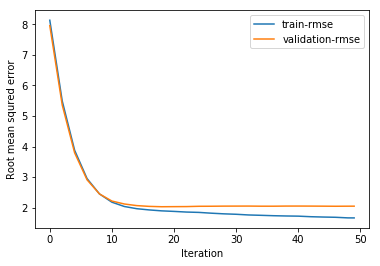

In [16]:
metrics_to_plot = ["train-rmse", "validation-rmse"]
for metric in metrics_to_plot:
    steps, data = get_data(trial, metric)
    plt.plot(steps, data, label=metric)
plt.xlabel('Iteration')
plt.ylabel('Root mean squred error')
plt.legend()
plt.show()

### Feature importances

We can also visualize the feature importances as determined by
[xgboost.get_fscore()](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_fscore).
Note that feature importances with zero values are not included here
(which means that those features were not used in any split condisitons).

In [17]:
def plot_collections(trial, collection_name, ylabel=''):
    
    plt.figure(
        num=1, figsize=(8, 8), dpi=80,
        facecolor='w', edgecolor='k')

    features = trial.collection(collection_name).get_tensor_names()

    for feature in sorted(features):
        steps, data = get_data(trial, feature)
        label = feature.replace('/' + collection_name, '')
        plt.plot(steps, data, label=label)

    plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
    plt.xlabel('Iteration')
    plt.ylabel(ylabel)
    plt.show()

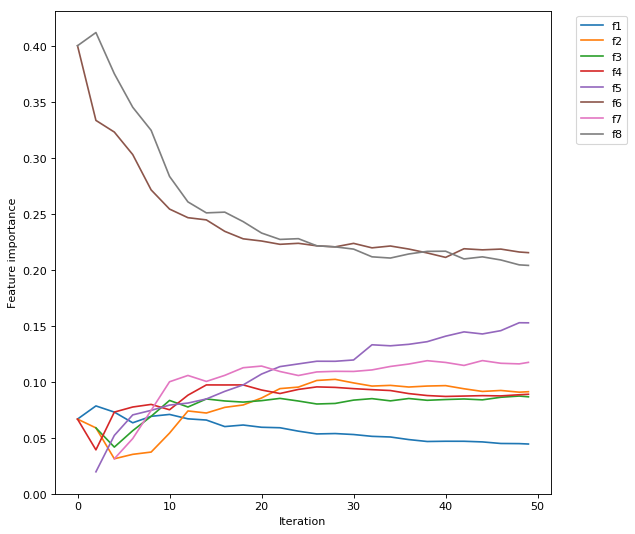

In [18]:
plot_collections(trial, "feature_importance", "Feature importance")

### SHAP

[SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) is
another approach to explain the output of machine learning models.
SHAP values represent a feature's contribution to a change in the model output.

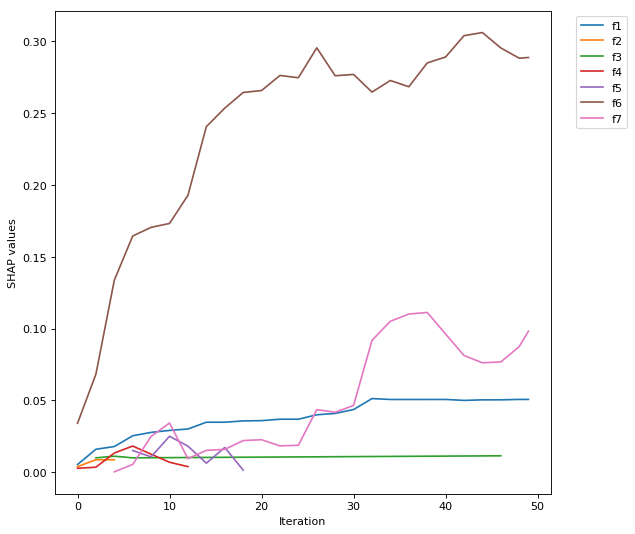

In [19]:
plot_collections(trial, "average_shap", "SHAP values")

We also have an example at the end of this notebook that demonstrates how to use a custom rule in Tornasole. Before moving further, let's take some detailed look at Tornasole, some of which were touched upon above.


## Enabling Tornasole in the training script

The first step to using Tornasole is to save tensors from the training job. The containers we provide in SageMaker come with Tornasole library installed, which needs to be used to enable Tornasole in your training script.

To enable Tornasole in the training script, you need to create and pass TornasoleHook, a construct Tornasole exposes to save tensors. Here's how you will need to modify your training script.

First, you need to import `tornasole.xgboost`. 
```
import tornasole
import tornasole.xgboostas tx
```
Then create the TornasoleHook by specifying what you want to save and when you want to save them.
```
hook = tx.TornasoleHook(include_collections=['metric','feature_importance'],
                        save_config=tornasole.SaveConfig(save_interval=5))
```
Now pass this hook as a callback function to the Booster object's train method.
```
import xgboost

bst = xgboost.train(..., callbacks=[hook])
```

Refer to our example script [xgboost_abalone_basic_hook_demo.py](../scripts/xgboost_abalone_basic_hook_demo.py) for examples of using Tornasole with the XGBoost interface.

Refer [DeveloperGuide_XGBoost.md](../../DeveloperGuide_XG.md) for more details on the APIs Tornasole provides to help you save tensors.

## Enabling Tornasole with SageMaker

#### Storage
The tensors saved by Tornasole are, by default, stored in the S3 output path of the training job, under the folder **`/tensors-<job name>`**. This is done to ensure that we don't end up accidentally overwriting the tensors from a training job with the others. Rules evaluation require separation of the tensors paths to be evaluated correctly.

If you don't provide an S3 output path to the estimator, SageMaker creates one for you as: **`s3://sagemaker-<region>-<account_id>/`**

This path is used to create a Tornasole Trial taken by Rules (see below).

#### New Parameters 
The new parameters in Sagemaker Estimator to look out for are

- `debug` :(bool)
This indicates that debugging should be enabled for the training job. 
Setting this as `True` would make Tornasole available for use with the job

- `rules_specification`: (list[*dict*])
You can specify any number of rules to monitor your SageMaker training job. This parameter takes a list of python dictionaries, one for each rule you want to enable. Each `dict` is of the following form:
```
{
    "RuleName": <str>       
        # The name of the class implementing the Tornasole Rule interface. (required)

    "SourceS3Uri": <str>    
        # S3 URI of the rule script containing the class in 'RuleName'. 
        # This is not required if you want to use one of the
        # First Party rules provided to you by Amazon. 
        # In such a case you can leave it empty or not pass it. 
        # If you want to run a custom rule 
        # defined by you, you will need to define the custom rule class in a python 
        # file and provide it to SageMaker as a S3 URI. 
        # SageMaker will fetch this file and try to look for the rule class 
        # identified by RuleName in this file.
    
    "InstanceType": <str>   
        # The ML instance type which should be used to run the rule evaluation job
        
    "VolumeSizeInGB": <int> 
        # The volume size to store the runtime artifacts from the rule evaluation 
        
    "RuntimeConfigurations": {
        # Map defining the parameters required to instantiate the Rule class and
        # parameters regarding invokation of the rule (start-step and end-step)
        # This can be any parameter taken by the rule. 
        # Every value here needs to be a string. 
        # So when you write custom rules, ensure that you can parse each argument 
        # from a string.
        #
        # PARAMS CAN BE
        #
        # STANDARD PARAMS FOR RULE EXECUTION
        # "start-step": <str>
        # "end-step": <str>
        # "other-trials-paths": <str> (';' separated list of s3 paths as a string)
        # "logging-level": <str> (can be one of "CRITICAL", "FATAL", "ERROR", 
        #                         "WARNING", "WARN", "DEBUG", "NOTSET")
        #
        # ANY OTHER PARAMETER TAKEN BY THE RULE
        # "parameter" : <str>
        # <str>: <str>
    }
}
```

### Inputs
Just a quick reminder if you are not familiar with script mode in SageMaker. You can pass command line arguments taken by your training script with a hyperparameter dictionary which gets passed to the SageMaker Estimator class. You can see this in the examples below.

### Rules
Rules are the medium by which Tornasole executes a certain piece of code regularly on different steps of the job.
They can be used to assert certain conditions during training, and raise Cloudwatch Events based on them that you can
use to process in any way you like. 

Tornasole comes with a set of **First Party rules** (1P rules).
You can also write your own rules looking at these 1P rules for inspiration. 
Refer [DeveloperGuide_Rules.md](../../../../rules/DeveloperGuide_Rules.md) for more on the APIs you can use to write your own rules as well as descriptions for the 1P rules that we provide. 
 
Here we will talk about how to use Sagemaker to evalute these rules on the training jobs.


##### 1P Rule 
If you want to use a 1P rule. Specify the RuleName field with the 1P RuleName, and the rule will be automatically applied. You can pass any parameters accepted by the rule as part of the RuntimeConfigurations dictionary. Rules constructor take trial as parameter.  
A Trial in Tornasole's context refers to a training job. It is identified by the path where the saved tensors for the job are stored.  
A rule takes a `base_trial` which refers to the job whose run invokes the rule execution. 

**Note:** A rule can be written to compare & analyze tensors across training jobs. A rule which needs to compare tensors across trials can be run by passing the argument `other_trials`. The argument `base_trial` will automatically be set by SageMaker when executing the rule. The parameter `other_trials` (if taken by the rule) can be passed by passing `other-trials-paths` in the RuntimeConfigurations dictionary. The value for this argument should be `;` separated list of S3 output paths where the tensors for those trials are stored.

Here's a example of a complex configuration for the SimilarAcrossRuns (which accepts one other trial and a regex pattern) where we ask for the rule to be invoked for the steps between 10 and 100.

``` 
rules_specification = [ 
    {
      "RuleName": "SimilarAcrossRuns",
      "InstanceType": "ml.c5.4xlarge",
      "VolumeSizeInGB": 10,
      "RuntimeConfigurations": {
         "other_trials": "s3://sagemaker-<region>-<account_id>/past-job",
         "include_regex": ".*",
         "start-step": "10",
         "end-step": "100"
       }
    }
]
```
List of 1P rules and details about the rules can be found in *First party rules* section in [DeveloperGuide_Rules.md](../../../../rules/DeveloperGuide_Rules.md)  


##### Custom rule
In this case you need to define a custom rule class which inherits from `tornasole.rules.Rule` class.
You need to provide Sagemaker the S3 location of the file which defines your custom rule classes as the value for the field `SourceS3Uri`. Again, you can pass any arguments taken by this rule through the RuntimeConfigurations dictionary. Note that the custom rules can only have arguments which expect a string as the value except the two arguments specifying trials to the Rule. Refer section *Writing a rule* in [DeveloperGuide_Rules.md](../../../../rules/DeveloperGuide_Rules.md) for more details.

Here's an example:
```
rules_specification = [
    {
      "RuleName": "CustomRule",
      "SourceS3Uri": "s3://tornasole-test/rule-script/custom_rule.py",
      "InstanceType": "ml.c5.4xlarge",
      "VolumeSizeInGB": 10,
      "RuntimeConfigurations": {
         "threshold" : "0.5"
       }
    }
]
```

### CloudWatch Event Integration for Rules
When the status of training job or rule execution job change (i.e. starting, failed), TrainingJobStatus [CloudWatch events](https://docs.aws.amazon.com/sagemaker/latest/dg/cloudwatch-events.html) are emitted.  

You can see in the response to `describe_rule_execution_jobs()` above, the details about the cloudwatch event that was emitted due to rule success/failure. It would look like the following.
> Created CW event Rule: arn:aws:events:us-east-2:072677473360:rule/RuleEvaluationConditionMetRule-tornasole-simple-demo-ExplodingTe
> Please monitor the rule job statuses by going to CloudWatch->Events->Rule->Monitoring

You can configure a CloudWatch event rule to receive and process these events by setting up a target (Lambda function, SNS) as follows:

- Configure the [SageMaker TrainingJobStatus CW event](https://docs.aws.amazon.com/AmazonCloudWatch/latest/events/EventTypes.html#sagemaker_event_types) to include rule job statuses associated with the training job
- Configure the CW event to be emitted when a RuleStatus changes
- Create a CloudWatch event rule that monitors the Training Job customer started
- Set a Target (Lambda funtion, SQS) for the CloudWatch event rule that processes the event, and triggers an alarm for the customer based on the RuleStatus. 

Refer to [this page](https://docs.aws.amazon.com/sagemaker/latest/dg/cloudwatch-events.html) for more details. 

## Custom rule: Single Feature Importance

In this case you need to define a custom rule class which inherits from `tornasole.rules.Rule` class.
You need to provide Sagemaker the S3 location of the file which defines your custom rule classes as the value for the field `SourceS3Uri`.
Again, you can pass any arguments taken by this rule through the RuntimeConfigurations dictionary. 
Note that the custom rules can only have arguments which expect a string as the value except the two arguments 
specifying trials to the Rule. Refer [DeveloperGuide_Rules.md](../../../rules/DeveloperGuide_Rules.md) for more.

In the following code cell, we write a custom rule named `SingleFeatureImportance`
that checks if any feature importance in a given collection goes out of the
specified range.

In [20]:
%%writefile /tmp/custom_rule.py

from tornasole.rules.rule import Rule

class SingleFeatureImportance(Rule):
    def __init__(
            self,
            base_trial,
            collection_name,
            num_features=None,
            min_importance_ratio=0,
            max_importance_ratio=1
            ):
        """
        This rule checks the following statement:
        - In a given collection, each feature should have importance
          satisfying the following conditions:
          a) min_importance*(1/feature_no) <= feature importance
          b) feature_importance <= max_importance*(1/feature_no)

        :param base_trial: the trial whose execution will invoke the rule
        :param min_importance_ratio: the minimum allowed importance (as a proportion of 1/feature_no)
        :param max_importance_ratio: the maximum allowed importance (as a proportion of 1/feature_no)
        """
        self.collection_name = collection_name
        self.tensor_names = base_trial.collection(self.collection_name).get_tensor_names()
        self.num_features = len(self.tensor_names) if num_features is None else int(num_features)
        self.min_importance_ratio = float(min_importance_ratio)
        self.max_importance_ratio = float(max_importance_ratio)

        super().__init__(base_trial, other_trials=None)
        
        self.logger.info("FeatureImportance rule created.")

    def invoke_at_step(self, step, **kwargs):
        
        min_importance = self.min_importance_ratio * (1 / self.num_features)
        max_importance = self.max_importance_ratio * (1 / self.num_features)

        failed = []

        for name in self.tensor_names:
            
            if step not in self.base_trial.tensor(name).steps():
                importance = 0
            else:
                importance = self.base_trial.tensor(name).value(step)

            if importance < min_importance:
                self.logger.debug(f"Step {step} feature {name} has importance {importance}<{min_importance}")
                failed.append((name, importance))
            elif max_importance < importance:
                self.logger.debug(f"Step {step} feature {name} has importance {importance}>{max_importance}")
                failed.append((name, importance))

        self.logger.info(failed)
        self.logger.info(f"Step {step} had {len(failed)} features with out-of-band values")

        return True if failed else False

Writing /tmp/custom_rule.py


We need to upload this to a bucket in the same region where we want to run the job. We have chosen a default bucket below. Please change it to the bucket you want. We will now create this bucket if it does not exist, and upload this file. We will then specify this path when starting the job as `SourceS3Uri`.

In [21]:
ACCOUNT_ID = boto3.client('sts').get_caller_identity().get('Account')
BUCKET = f'tornasole-resources-{ACCOUNT_ID}-{REGION}'

CUSTOM_RULE_PATH = '/tmp/custom_rule.py'

PREFIX = os.path.join('rules', os.path.basename(CUSTOM_RULE_PATH))

import os
s3 = boto3.resource('s3')
bucket = s3.Bucket(BUCKET)
if not bucket.creation_date:
    s3.create_bucket(Bucket=BUCKET, CreateBucketConfiguration={'LocationConstraint': REGION})
s3.Object(BUCKET, PREFIX).put(Body=open(CUSTOM_RULE_PATH, 'rb'))
SOURCE_S3_URI = f's3://{BUCKET}/{PREFIX}'
print(f"Upload to {SOURCE_S3_URI}")

Upload to s3://tornasole-resources-959484541615-us-west-2/rules/custom_rule.py


In [22]:
estimator = Estimator(
    base_job_name="xgboost-custom-rule-tornasole",
    hyperparameters=hyperparameters,
    image_name=docker_image_name,
    role=ROLE,
    train_instance_count=1,
    train_instance_type="ml.m4.4xlarge",
    debug=True,
    rules_specification = [
        {
        "RuleName": "SingleFeatureImportance",
        "SourceS3Uri": SOURCE_S3_URI,
        "InstanceType": "ml.c5.xlarge",
        "VolumeSizeInGB": 10,
        "RuntimeConfigurations": {
            "collection_name": "average_shap",
            "num_features": "8",
            "min_importance_ratio": "0.0",
            "max_importance_ratio": "2.0"
            }
        }
    ]
)

In [23]:
estimator.fit(wait=False)

job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)

description["TrainingJobStatus"]

'InProgress'

In [24]:
description["DebugConfig"]

{'DebugHookConfig': {'LocalPath': '/opt/ml/output/tensors',
  'S3OutputPath': 's3://sagemaker-us-west-2-959484541615/tensors-xgboost-custom-rule-tornasole-2019-09-10-05-31-03-332',
  'DebugHookSpecificationList': []},
 'RuleConfig': {'RuleSpecificationList': [{'RuleName': 'SingleFeatureImportance',
    'RuleEvaluatorImage': '453379255795.dkr.ecr.us-west-2.amazonaws.com/script-rule-executor:latest',
    'SourceS3Uri': 's3://tornasole-resources-959484541615-us-west-2/rules/custom_rule.py',
    'InstanceType': 'ml.c5.xlarge',
    'VolumeSizeInGB': 10,
    'RuntimeConfigurations': {'collection_name': 'average_shap',
     'max_importance_ratio': '2.0',
     'min_importance_ratio': '0.0',
     'num_features': '8'}}]}}

As we can visually verify in the [Data Analysis](#Data-Analysis---Manual) section above,
the SHAP value of feature will become significant, and we expect our rule to throw a
`RuleEvaluationConditionMet` exception.

In [27]:
estimator.describe_rule_execution_jobs()

Wait to get status for Rule Execution Jobs...
RuleName: SingleFeatureImportance
RuleStatus: RuleExecutionError
FailureReason: ClientError: RuleEvaluationConditionMet: Evaluation of the rule SingleFeatureImportance at step 16 resulted in the condition being met
Traceback (most recent call last):
  File "train.py", line 214, in execute
    exec(_SYMBOLIC_INVOKE_RULE.format(self.start_step, self.end_step), globals(), exec_local)
  File "<string>", line 2, in <module>
  File "/usr/local/lib/python3.7/site-packages/tornasole/rules/rule_invoker.py", line 84, in invoke_rule
    raise e
  File "/usr/local/lib/python3.7/site-packages/tornasole/rules/rule_invoker.py", line 79, in invoke_rule
    rule_obj.invoke(step)
  File "/usr/local/lib/python3.7/site-packages/tornasole/rules/rule.py", line 56, in invoke
    raise RuleEvaluationConditionMet(self.rule_name, step)
tornasole.exceptions.RuleEvaluationConditionMet: Evaluation of the rule SingleFeatureImportance at step 16 resulted in the condition

[{'RuleName': 'SingleFeatureImportance',
  'RuleExecutionJobArn': 'arn:aws:sagemaker:us-west-2:959484541615:training-job/singlefeatureimportance-3fc38a10a6c578e86746248706aad00e',
  'RuleStatus': 'RuleExecutionError',
  'FailureReason': 'ClientError: RuleEvaluationConditionMet: Evaluation of the rule SingleFeatureImportance at step 16 resulted in the condition being met\nTraceback (most recent call last):\n  File "train.py", line 214, in execute\n    exec(_SYMBOLIC_INVOKE_RULE.format(self.start_step, self.end_step), globals(), exec_local)\n  File "<string>", line 2, in <module>\n  File "/usr/local/lib/python3.7/site-packages/tornasole/rules/rule_invoker.py", line 84, in invoke_rule\n    raise e\n  File "/usr/local/lib/python3.7/site-packages/tornasole/rules/rule_invoker.py", line 79, in invoke_rule\n    rule_obj.invoke(step)\n  File "/usr/local/lib/python3.7/site-packages/tornasole/rules/rule.py", line 56, in invoke\n    raise RuleEvaluationConditionMet(self.rule_name, step)\ntornasole

This concludes this notebook. For more information see the documentation at  
- https://github.com/awslabs/tornasole_core